<a href="https://colab.research.google.com/github/k3larra/XAI-F/blob/main/Falsify_XAI_ISMIS4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Benchmarking XAI 4
Comparing explanations for four neural networks to check how well aligned their internal knowledge representation are.

We download four models pretrained on ImageNet1000, Resnet101, ResNet151, GoogleNet and Inception V3. 

The XAI method Occlusion is selected since it measures importance of squares independepent of the internal network architecture. We sellected "superpixels" of 16x16pixels. Occlusion then estimates the importance of these squares for the final classification. There is then four esitmates(one per model) for each square. By calculating standard deviation for the coreseponding four squares we get an estimate of how much the model/xai method disagree. Mean value of all std's in an imagea and mean value of highest 10 stds are saved.

The datasets used are from other studies and the numbers and images calculated here are used to complement the studies.



In [ ]:
#Cleaning if needed
! rm -r ISMIS 
! rm -r XAI-F
! rm -r testshapes2
! rm imagenet_classes.txt

rm: cannot remove 'ISMIS': No such file or directory
rm: cannot remove 'XAI-F': No such file or directory
rm: cannot remove 'testshapes2': No such file or directory
rm: cannot remove 'imagenet_classes.txt': No such file or directory


# Setup

In [ ]:
#XAI methods
%%capture
! pip install captum #kaggle

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
import os
import sys
import urllib
import json
import random
#import requests
#from flask import Flask, flash, request, redirect, url_for, send_from_directory, after_this_request, jsonify, make_response
#from werkzeug.utils import secure_filename
from io import StringIO ##For images
from io import BytesIO
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from torchvision import models
from torchvision import transforms
from torchvision.transforms import functional as transformsF
from captum.attr import IntegratedGradients
#from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import GuidedGradCam
from captum.attr import LayerGradCam
from captum.attr import LayerAttribution
from captum.attr import GradientShap
from captum.attr import Lime
from captum.attr import visualization as viz
#Extras for this test
import matplotlib.pyplot as plt
print(torch.__version__)
from zipfile import ZipFile
from random import randint
from torch.utils.data import Dataset
from torchvision import datasets

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import time
import os
import copy

1.11.0+cu113


In [ ]:
# def normalise(x):
#   #print("Shape:",x.shape)
#   #print("Mean:",torch.mean(x))
#   #print("Std:",torch.std(x))
#   if not all(x[0] == 0): # non all-zero vector
#       # linear rescale to range [0, 1]
#       x -= x.min() # bring the lower range to 0
#       x /= x.max() # bring the upper range to 1
#   return x
# saliency_map =  torch.ones(1, 16)
# x = torch.rand(4, 4)
# x = torch.flatten(x)
# x=x[None, :]
# #Remove negative values since not concept is hard to understand
# x = torch.nn.functional.relu(x)
# x = normalise(x)
# saliency_map=torch.cat((saliency_map,x),0)
# print(saliency_map)
# std_saliency_map = torch.std(saliency_map, 0, unbiased=False) 
# print(std_saliency_map.shape)
# print(std_saliency_map)


# LOAD MODELS! 

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
! git clone https://github.com/k3larra/XAI-F
with ZipFile('/content/XAI-F/testset2.zip', 'r') as archive:
  archive.extractall('/content/testshapes2')

Cloning into 'XAI-F'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 45 (delta 14), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (45/45), done.


In [ ]:
with ZipFile('/content/XAI-F/human_saliency.zip', 'r') as archive:
  archive.extractall('/content/')

In [ ]:
# from os import listdir
# from os.path import isfile, join
# import csv

# shape_path = "/content/testshapes2"

# with open(shape_path + '/shapes.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(['image_location', 'label']) # Write header
#     for dirs in listdir(shape_path):
# #         print(dirs)
#         if(dirs.endswith(".csv")):
#             continue
#         for f in listdir(join(shape_path, dirs)):
#             if(join(shape_path, dirs, f).endswith(".csv")):
#                 continue
#             elif isfile(join(shape_path, dirs, f)):
#                 writer.writerow([join(dirs, f), dirs])

In [ ]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
num_classes = len(categories)

def label_to_idx(label):
  return categories.index(label)

def idx_to_label(idx):
  #position = val_list.index(idx)
  return categories[idx]

--2022-05-22 13:27:52--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2022-05-22 13:27:52 (40.0 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [ ]:
%%capture
# Johan o Niklas ResNet 101 occlusion o GradCAM | Julia ResNet152 + LIME | Sofia, ResNet 152, LIME, SHAP, GradCAM 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.hub._validate_not_a_forked_repo=lambda a,b,c: True #Skum grej från https://github.com/pytorch/pytorch/issues/61755
model_resnet101 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
model_resnet101.eval()
model_resnet101 = model_resnet101.to(device)
model_resnet152 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
model_resnet152.eval()
model_resnet152 = model_resnet152.to(device)
model_googlenet = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
model_googlenet.eval()
model_googlenet = model_googlenet.to(device)
model_inception_v3 = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model_inception_v3.eval()
model_inception_v3 = model_inception_v3.to(device)
model_efficientnet_b4 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
model_efficientnet_b4.eval()
model_efficientnet_b4 =  model_efficientnet_b4.to(device)

In [ ]:
model_efficientnet_b4 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b4', pretrained=True)
model_efficientnet_b4.eval()
model_efficientnet_b4 =  model_efficientnet_b4.to(device)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Downloading: "https://api.ngc.nvidia.com/v2/models/nvidia/efficientnet_b4_pyt_amp/versions/20.12.0/files/nvidia_efficientnet-b4_210412.pth" to /root/.cache/torch/hub/checkpoints/nvidia_efficientnet-b4_210412.pth


  0%|          | 0.00/74.5M [00:00<?, ?B/s]

# XAI Methods - Captum


In [ ]:
method="blended_heat_map"#"heat_map"#"blended_heat_map"
sign="all" #positive
alpha_overlay = 0.8
fig_size=(6,6)
default_cmap = LinearSegmentedColormap.from_list('custom green', 
                                                 [(0, '#000000'),
                                                  (0.5, '#000000'),
                                                  (1, '#8df505')], N=3)

In [ ]:
def show_image(image, prediction):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.title(prediction)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
from skimage import io, transform
from PIL import Image

eval_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        #transforms.CenterCrop(224),
        transforms.ToTensor()
    ])
transform_normalize = transforms.Normalize( #LH added we need this for imagenet or?? Alberto?
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

def transform_eval_data(img_path, eval_transform = None):
  image = Image.open(img_path).convert('RGB')
  
  if eval_transform:
      image = eval_transform(image)
      image = transform_normalize(image) #LH added for Imagenet
  image = image.float()
  return image
        

## Methods


In [ ]:
# def calculate_layered_gradcam(experiment_model, target_label, input_img, top_candidates, top_probs, img_index, save_path="", save=False):
#   print("layered_gradcam captum")
#   input_img.requires_grad = True
#   experiment_model = experiment_model.to(device)
#   input_img = input_img.to(device)
#   if experiment_model.__class__.__name__ == 'Inception3':
#     layer_gradcam = LayerGradCam(experiment_model, experiment_model.Mixed_7c.branch_pool) #Inception v3
#     print("Inception3")
#   elif experiment_model.__class__.__name__ == 'GoogLeNet':
#     layer_gradcam = LayerGradCam(experiment_model, experiment_model.inception5b.branch4)
#     print("GoogLeNet")
#   elif experiment_model.__class__.__name__ == 'ResNet':
#     #layer_gradcam = LayerGradCam(experiment_model, experiment_model.layer4[-1])
#     layer_gradcam = LayerGradCam(experiment_model, experiment_model.layer4[1].conv2)
#     print("ResNet")
#   else:
#     print("No matching conv layer ")
#   attributions = layer_gradcam.attribute(input_img, target=target_label)
#   add_saliency_row(attributions)
#   attributions = LayerAttribution.interpolate(attributions, input_img.shape[2:])
#   # Remove the dummy batch dimension
#   input_img = input_img.squeeze()
#   result = viz.visualize_image_attr(attributions[0].cpu().permute(1,2,0).detach().numpy(),
#                               input_img.cpu().permute(1,2,0).detach().numpy(), 
#                               #cmap=default_cmap,
#                               alpha_overlay=alpha_overlay,
#                               method=method,
#                               sign=sign,
#                               fig_size=(6,6))
#   if save:
#     n=str(img_index)
#     result[0].savefig(save_path+'image'+n+'_GC_captum.PNG',bbox_inches='tight', pad_inches = 0)  
#   print(target_label, idx_to_label(top_candidates[0]), np.round(top_probs[0].item(),2))
#   calc_show_difference(input_img,save_path)

In [ ]:
def calculate_occlusion(experiment_model, target_label, input_img, top_candidates, top_probs, img_index,  save_path="", save=False):
  print("occlusion")
  experiment_model = experiment_model.to(device)
  input_img = input_img.to(device)
  occlusion = Occlusion(experiment_model)
  attributions = occlusion.attribute(input_img, 
                                       target=target_label,
                                       strides=(3, 32, 32),
                                       sliding_window_shapes=(3, 32, 32),
                                       baselines=0)
  #add_saliency_row(saliency_attrib,attributions)
  input_img = input_img.squeeze()
  # attr_combined = np.sum(attributions.squeeze().cpu().permute(1,2,0).detach().numpy(), axis=2)
  # attr_combined = (attr_combined > 0) * attr_combined
  # result = viz.visualize_image_attr(attributions[0].cpu().permute(1,2,0).detach().numpy(),
  #                             input_img.cpu().permute(1,2,0).detach().numpy(), 
  #                             #cmap=default_cmap,
  #                             alpha_overlay=alpha_overlay,
  #                             method="blended_heat_map",
  #                             sign="positive",
  #                             fig_size=fig_size)

  if save:
    n=str(img_index)
    # result[0].savefig(save_path+'image'+n+'_Occ.PNG',bbox_inches='tight', pad_inches = 0)
  print(target_label, idx_to_label(top_candidates[0]), np.round(top_probs[0].item(),2))
  return attributions

# Helpers


In [ ]:
def eval_model(experiment_set, test_model, print_eval=False):
  since = time.time()
  test_model.eval()   # Set model to evaluate mode

  for experiment_sample in experiment_set:
    torch.set_printoptions(sci_mode=False)

    with torch.no_grad():
      input = experiment_sample
      input = torch.unsqueeze(input, 0)
      input = input.to(device)
      #print(input.shape)
      output = test_model(input)
      _, pred = torch.max(output, 1)

      input= input.cpu().squeeze()
      smax = F.softmax(output,dim=1)
      print("prediction: ", pred, ", label: ", idx_to_label(pred))

      if print_eval:
        show_image(input.permute(1,2,0), idx_to_label(pred))
        print(smax)
        print("---------")

def get_all_files(experiment_path):
  loaded_files = []
  for f in sorted(os.listdir(experiment_path)):
    if f.endswith('.PNG') or f.endswith('.png'):
      loaded_files.append(f)
  #print(loaded_files)
  return loaded_files

def load_experiment_data(experiment_path, test_model, plot_data=False, evaluate_model=False, print_evaluation=False):
  experiment_set = []
  eval_dir = get_all_files(experiment_path)
  eval_size = len(eval_dir)
  for i in range(eval_size):
    experiment_set.append(transform_eval_data(experiment_path + eval_dir[i]
                                      ,eval_transform))
  if plot_data:
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        #sample_idx = torch.randint(len(shapes_dataset), size=(1,)).item() # Get rnd_id
        img = experiment_set[i-1] # index dataset (gets you the img and label - index)
        figure.add_subplot(rows, cols, i)
        plt.title(img.shape)
        plt.axis("off")
    #    plt.imshow(img.squeeze(), cmap="gray") # if the image is grayscale
        plt.imshow(img.permute(1,2,0)) # put channel as the last dimension
    plt.show()
  if evaluate_model:
    eval_model(experiment_set, test_model, print_evaluation)
  return experiment_set

def process_input(input_img, experiment_model, debug=False):
  input_img = input_img.to(device)
  output = experiment_model(input_img)
  probabilities = F.softmax(output[0], dim=0)
  top_prob, top_catid = torch.topk(probabilities, num_classes)
  jsonData={}
  for i in range(top_prob.size(0)):
      prediction={}
      prob=top_prob[i].item()
      prediction["probability"] = np.round(top_prob[i].item(),9)
      prediction["label"] = idx_to_label(top_catid[i])
      prediction["labelid"] = top_catid[i].item()
      jsonData[i]=prediction
  if debug:
    #print(label,jsonData)
    print(jsonData)
  return top_catid, top_prob, jsonData

In [ ]:
import json

def run_experiment_shapes(experiment_model, experiment_path, experiment_name, save_path="", label_id=0, index=-1, save=False, debug=False):
  print(experiment_name)
  experiment_set = load_experiment_data(experiment_path,  experiment_model, plot_data=False, evaluate_model = False, print_evaluation=False)
  print("------------------")
  path_to_save = save_path + experiment_name.replace(" ", "") + "/"
  print("Save Path: ", path_to_save)
  if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)
  json_data = {}
  if index == -1: # Iterate all the experiment set! else only the specific index is 
    for idx, experiment_sample in enumerate(experiment_set):
      ignore_indices = []
      if idx in ignore_indices:
        continue
      experiment_sample = experiment_sample.unsqueeze(0)
      top_candidates, top_probs, jdata = process_input(experiment_sample, experiment_model, debug=debug)
      json_data[idx] = jdata      
      calculate_occlusion(experiment_model,saliency_attrib, 
                              target_label=top_candidates[label_id],
                              input_img=experiment_sample,
                              top_candidates=top_candidates, top_probs=top_probs,
                              img_index=idx, save_path=path_to_save, save=save)
      save_json = json.dumps(json_data)
      with open(path_to_save + 'label_info.json', 'w') as outfile:
          outfile.write(save_json)
  else:
      experiment_sample = experiment_set[index]
      experiment_sample = experiment_sample.unsqueeze(0)
      top_candidates, top_probs, jdata = process_input(experiment_sample, experiment_model, debug=debug)
      target_label = top_candidates[label_id].item()
      json_data[0] = jdata
      saliency_map=calculate_occlusion(experiment_model,
                              target_label=target_label,
                              input_img=experiment_sample,
                              top_candidates=top_candidates, top_probs=top_probs,  
                              img_index=index, save_path=path_to_save, save=save)
      save_json = json.dumps(json_data)
      with open(path_to_save +"image"+str(index)+'label_info.json', 'w') as outfile:
          outfile.write(save_json) 
  return saliency_map

##ML model Similarity and difference measurement

In [ ]:
def add_saliency_row(saliency_map,saliency_attrib,do_round_special=True):
  saliency_attrib = torch.flatten(saliency_attrib)
  saliency_attrib=saliency_attrib[None, :] # remove empty dimension 
  saliency_attrib = torch.nn.functional.relu(saliency_attrib) #Remove negative values since not concept is hard to understand
  saliency_attrib = normalise(saliency_attrib)
  if do_round_special:
    saliency_attrib=round_special(saliency_attrib)
  torch.topk(saliency_attrib,10)
  if int(torch.sum(saliency_map).item())==0:  #ALberto make this nice......
    saliency_map=saliency_attrib.clone().detach()
  else:
    saliency_map=torch.cat((saliency_map,saliency_attrib),0)
  return saliency_map

def calc_show_difference(saliency_map_aggregate,experiment_path,save_path,image_index):
  print("OBS: Shape rows should reflect the number of models tested", saliency_map_aggregate.shape)
  if(saliency_map_aggregate.size()[0]>1): #Test to there are at least two saliency maps to compare
    experiment_set = load_experiment_data(experiment_path,  "dummy_name", plot_data=False, evaluate_model = False, print_evaluation=False) #Only usin this to get the image sp model name not important
    experiment_sample = experiment_set[image_index]
    input_img = experiment_sample.unsqueeze(0)
    input_img = input_img.to(device)
    input_img = input_img.squeeze()
    std_saliency_map_aggregate = torch.std(saliency_map_aggregate, 0, unbiased=False) ###Should unbiased be True since it is a sample from different models in reality????
    if (torch.sum(std_saliency_map_aggregate).item())!=0.0:  #Check so the saliency maps are not identical, gives 0 an an error in viz
      print("HERE WHAT ALL THE MODELS DISAGREE ON")
      std_saliency_map_aggregate_image=torch.reshape(std_saliency_map_aggregate, (1,3,224,224))
      attributions = LayerAttribution.interpolate(torch.negative(std_saliency_map_aggregate_image), [224,224]) #and this?
      result_std=viz.visualize_image_attr(attributions[0].cpu().permute(1,2,0).detach().numpy(),
                                    input_img.cpu().permute(1,2,0).detach().numpy(),  
                                    #cmap=default_cmap,
                                    alpha_overlay=alpha_overlay,
                                    method="blended_heat_map",
                                    sign="all",
                                    fig_size=(6,6))
      mean_saliency_map_aggregate = torch.mean(saliency_map_aggregate, 0) 
      print("HERE WHAT ALL THE MODELS AGREE ON")
      mean_saliency_map_aggregate=torch.reshape(mean_saliency_map_aggregate, (1,3,224,224))
      attributions = LayerAttribution.interpolate(mean_saliency_map_aggregate, [224,224]) #and this?
      result_mean=viz.visualize_image_attr(attributions[0].cpu().permute(1,2,0).detach().numpy(),
                                    input_img.cpu().permute(1,2,0).detach().numpy(),  
                                    #cmap=default_cmap,
                                    alpha_overlay=alpha_overlay,
                                    method="blended_heat_map",
                                    sign="all",
                                    fig_size=(6,6))
      std_saliency_map = np.mean(std_saliency_map_aggregate_image.squeeze().cpu().detach().numpy(), axis = 0) #Get the mean of colours 
      std_saliency_map = torch.flatten(torch.tensor(std_saliency_map[::32,::32]))  #Remove redundant numbers to make it 7x7 and flatten
      mean_saliency_map_aggregate_49 = np.mean(mean_saliency_map_aggregate.squeeze().cpu().detach().numpy(), axis = 0) #Get the mean of colours
      mean_saliency_map_aggregate_49 = torch.flatten(torch.tensor(mean_saliency_map_aggregate_49[::32,::32]))
      Dscore10 = int(round(std_saliency_map.size(dim=0)*0.1))
      Dscore20 = int(round(std_saliency_map.size(dim=0)*0.2))
      print("Mean of all standard deviations dim std_image","%.2f" % torch.mean(std_saliency_map).item())
      print("Mean of top 10% ("+str(Dscore10)+"st) standard deviations",
            "%.2f" % torch.mean(torch.topk(std_saliency_map,Dscore10)[0]).item())
      # print("Mean of top 20% ("+str(Dscore20)+"st) standard deviations",
            # "%.2f" % torch.mean(torch.topk(std_saliency_map,Dscore20)[0]).item())
      f=open(save_path+"image"+str(image_index)+"_result_compare.txt","w")
      f.write("Mean of all standard deviations "+ 
              str(round(torch.mean(std_saliency_map).item(),2))+"\n")
      f.write("Mean of top 10% ("+str(Dscore10)+"st) standard deviations "+
              str(round(torch.mean(torch.topk(std_saliency_map,Dscore10)[0]).item(),2))+"\n")
      #f.write("Mean of top 20% ("+str(Dscore20)+"st) standard deviations "+
      #        str(round(torch.mean(torch.topk(std_saliency_map,Dscore20)[0]).item(),2))+"\n")
      f.write(str(round(torch.mean(std_saliency_map).item(),2))+","
      +str(round(torch.mean(torch.topk(std_saliency_map,Dscore10)[0]).item(),2))+"\n")#+","
      #+str(round(torch.mean(torch.topk(std_saliency_map,Dscore20)[0]).item(),2))
      f.close()
      result_std[0].savefig(save_path+'std_image'+str(image_index)+'_std_occ.PNG',bbox_inches='tight', pad_inches = 0)
      result_mean[0].savefig(save_path+'mean_image'+str(image_index)+'_std_occ.PNG',bbox_inches='tight', pad_inches = 0)
      f=open(save_path+"result_compare_all.txt","a")
      f.write(str(image_index)+","+str(round(torch.mean(std_saliency_map).item(),3))+","+str(round(torch.mean(torch.topk(std_saliency_map,10)[0]).item(),3))+"\n")
      f.close()
    else:
      print("all tensors are belong to us")
  return   mean_saliency_map_aggregate_49,std_saliency_map

def normalise(x):
  if not all(x[0] == 0): 
      x -= x.min() # bring the lower range to 0
      x /= x.max() # bring the upper range to 1
  #print("top_norm",torch.topk(x,10)[0])
  return x

def round_special(x):
  #This method round 0-0.33 to 0, 0.33-0.66 to 0.5 and 0.66-1.0 to 1. #Hackiest ever....
  x=x*3
  x=torch.trunc(x)
  x[x==3] = 2 
  x=torch.round(x)
  x=x/2
  return x


###  Human saliency maps similarities and differences measurements

In [ ]:
import pandas as pd
def calc_D_score(experiment_path,file_name,image_path,image_index,save_path):
  print("File Path: ", file_name)
  print("Experiment Path: ", experiment_path)
  print("Save Path: ", save_path)
  print("Image Path: ", image_path, "image nr",image_index)
  experiment_set = load_experiment_data(image_path,  "dummy_name", plot_data=False, evaluate_model = False, print_evaluation=False) #Only usin this to get the image sp model name not important
  experiment_sample = experiment_set[image_index]
  input_img = experiment_sample.unsqueeze(0)
  input_img = input_img.to(device)
  input_img = input_img.squeeze()
  #plt.imshow(input_img)
  if not os.path.exists(save_path):
    os.makedirs(save_path)
  df=pd.read_csv(experiment_path+file_name, sep=',',header=None)
  saliency_map_aggregate = torch.tensor(df.values)
  #Plot stdev image
  std_saliency_map = torch.std(saliency_map_aggregate, 0, unbiased=False)
  std_saliency_map_upsampled = rebuild_saliency_map(std_saliency_map)
  attributions = LayerAttribution.interpolate(torch.negative(std_saliency_map_upsampled), [224,224]) #and this?
  print("HERE WHAT ALL THE HUMANS DISAGREE ON")
  result_std=viz.visualize_image_attr(attributions[0].cpu().permute(1,2,0).detach().numpy(),
                                    input_img.cpu().permute(1,2,0).detach().numpy(),  
                                    #cmap=default_cmap,
                                    alpha_overlay=alpha_overlay,
                                    method="blended_heat_map",
                                    sign="all",
                                    fig_size=(6,6))
  print("HERE WHAT ALL THE HUMANS AGREE ON")
  mean_saliency_map_aggregate = torch.mean(saliency_map_aggregate, 0)
  mean_saliency_map_upsampled = rebuild_saliency_map(mean_saliency_map_aggregate)
  attributions = LayerAttribution.interpolate(mean_saliency_map_upsampled, [224,224]) #and this?
  result_mean=viz.visualize_image_attr(attributions[0].cpu().permute(1,2,0).detach().numpy(),
                                    input_img.cpu().permute(1,2,0).detach().numpy(),  
                                    #cmap=default_cmap,
                                    alpha_overlay=alpha_overlay,
                                    method="blended_heat_map",
                                    sign="all",
                                    fig_size=(6,6))
  
  Dscore10 = int(round(std_saliency_map.size(dim=0)*0.1))
  Dscore20 = int(round(std_saliency_map.size(dim=0)*0.2))
  print("Mean of all standard deviations dim std_image","%.2f" % torch.mean(std_saliency_map).item())
  print("Mean of top 10% ("+str(Dscore10)+"st) standard deviations",
        "%.2f" % torch.mean(torch.topk(std_saliency_map,Dscore10)[0]).item())
  #print("Mean of top 20% ("+str(Dscore20)+"st) standard deviations",
  #      "%.2f" % torch.mean(torch.topk(std_saliency_map,Dscore20)[0]).item())
  f=open(save_path+"dispersion_result_"+file_name,"w")
  f.write("Mean of all standard deviations "+ str(round(torch.mean(std_saliency_map).item(),2))+"\n")
  f.write("Mean of top 10% ("+str(Dscore10)+"st) standard deviations "+
          str(round(torch.mean(torch.topk(std_saliency_map,Dscore10)[0]).item(),2))+"\n")
  # f.write("Mean of top 20% ("+str(Dscore20)+"st) standard deviations "+
  #         str(round(torch.mean(torch.topk(std_saliency_map,Dscore20)[0]).item(),2))+"\n")
  f.write(str(round(torch.mean(std_saliency_map).item(),2))+","
  +str(round(torch.mean(torch.topk(std_saliency_map,Dscore10)[0]).item(),2))#+","
  #+str(round(torch.mean(torch.topk(std_saliency_map,Dscore20)[0]).item(),2))
  +"\n")
  f.close()
  result_std[0].savefig(save_path+'std_image_'+file_name.split(".")[0]+str(image_index)+'.PNG',bbox_inches='tight', pad_inches = 0)
  result_mean[0].savefig(save_path+'mean_image_'+file_name.split(".")[0]+str(image_index)+'.PNG',bbox_inches='tight', pad_inches = 0)
  return mean_saliency_map_aggregate,std_saliency_map

def rebuild_saliency_map(map):
  map = map.reshape([7,7])
  map.unsqueeze_(0)
  map = map.repeat(3,1,1)
  map=torch.reshape(map, (1,3,7,7))
  return map

  

In [ ]:
def calc_mean_std_machine_maps(image_nbr=0):
    saliency_map=torch.zeros(1,150528) #Variable for collecting saliency maps for the different models 
    #saliency_map=torch.zeros(1,49)
    experiment_path = "/content/testshapes2/study1/"
    save_path = '/content/ISMIS/study1/'
    saliency_attrib=run_experiment_shapes(model_resnet101, experiment_path ,"resnet101", save_path,  0, image_nbr, True, True)
    saliency_map = add_saliency_row(saliency_map,saliency_attrib) 
    saliency_attrib=run_experiment_shapes(model_resnet152, experiment_path, "resnet152",  save_path, 0, image_nbr, True, True)
    saliency_map = add_saliency_row(saliency_map,saliency_attrib) 
    saliency_attrib=run_experiment_shapes(model_googlenet, experiment_path, "googlenet", save_path, 0, image_nbr, True, True)
    saliency_map = add_saliency_row(saliency_map,saliency_attrib) 
    saliency_attrib= run_experiment_shapes(model_inception_v3, experiment_path, "inception_v3", save_path, 0, image_nbr, True, True)
    saliency_map = add_saliency_row(saliency_map,saliency_attrib) 
    saliency_attrib= run_experiment_shapes( model_efficientnet_b4, experiment_path, "efficientnet_b4", save_path, 0, image_nbr, True, True)
    saliency_map = add_saliency_row(saliency_map,saliency_attrib)
    return calc_show_difference(saliency_map,experiment_path,save_path,image_nbr)

def visualise_difference(mean_saliency_map_human_aggregate,mean_saliency_map_machine_aggregate,image_path,image_index,save_path):
  disagre_importance = torch.subtract(mean_saliency_map_human_aggregate,mean_saliency_map_machine_aggregate)
  disagre_importance = torch.abs(disagre_importance)
  disagre_importance = rebuild_saliency_map(disagre_importance)
  experiment_set = load_experiment_data(image_path,  "dummy_name", plot_data=False, evaluate_model = False, print_evaluation=False) #Only usin this to get the image sp model name not important
  experiment_sample = experiment_set[image_index]
  input_img = experiment_sample.unsqueeze(0)
  input_img = input_img.to(device)
  input_img = input_img.squeeze()
  attributions = LayerAttribution.interpolate(torch.negative(disagre_importance), [224,224]) #and this?
  print("HUMAN MACHINE COMPARISON")
  result_diff=viz.visualize_image_attr(attributions[0].cpu().permute(1,2,0).detach().numpy(),
                                      input_img.cpu().permute(1,2,0).detach().numpy(),  
                                      #cmap=default_cmap,
                                      alpha_overlay=alpha_overlay,
                                      method="blended_heat_map",
                                      sign="all",
                                      fig_size=(6,6))
  if not os.path.exists(save_path):
    os.makedirs(save_path)
  result_diff[0].savefig(save_path+'H_M_DIFF_'+str(image_index)+'.png',bbox_inches='tight', pad_inches = 0)
  return result_diff


# Run experiments!

### Run the Human ML comparisons

In [ ]:
# animal="dromedar"
# image_index = 0
# animal="gorilla"
# image_index = 1
animal="tucan"
image_index = 2
human_saliency_map="design-team"
#human_saliency_map2="study"
#human_saliency_map="all"
save_path ='/content/ISMIS/human_saliency/'+animal+'/'
#save_path2 ='/content/ISMIS/human_machine/'+human_saliency_map+"vs"+human_saliency_map2+'/'+animal+'/'
save_path2 ='/content/ISMIS/human_machine/'+human_saliency_map+'/'+animal+'/'
saliency_map_human_aggregate = calc_D_score("/content/human_saliency/"+animal+"/",human_saliency_map+".txt","/content/testshapes2/study1/",image_index,save_path)
#saliency_map_human_aggregate2 = calc_D_score("/content/human_saliency/"+animal+"/",human_saliency_map2+".txt","/content/testshapes2/study1/",image_index,save_path)
saliency_map_machine_aggregate = calc_mean_std_machine_maps(image_index)
map = visualise_difference(saliency_map_human_aggregate[0],saliency_map_machine_aggregate[0],"/content/testshapes2/study1/",image_index,save_path2)
#map = visualise_difference(saliency_map_human_aggregate[0],saliency_map_human_aggregate2[0],"/content/testshapes2/study1/",image_index,save_path2)


### Run ML maps


In [ ]:
for x in range(3):
  saliency_map=torch.zeros(1,150528) #Variable for collecting saliency maps for the different models 
  #saliency_map=torch.zeros(1,49)
  experiment_path = "/content/testshapes2/study1/"
  save_path = '/content/ISMIS/study1/'
  saliency_attrib=run_experiment_shapes(model_resnet101, experiment_path ,"resnet101", save_path,  0, x, True, True)
  saliency_map = add_saliency_row(saliency_map,saliency_attrib) 
  saliency_attrib=run_experiment_shapes(model_resnet152, experiment_path, "resnet152",  save_path, 0, x, True, True)
  saliency_map = add_saliency_row(saliency_map,saliency_attrib) 
  saliency_attrib=run_experiment_shapes(model_googlenet, experiment_path, "googlenet", save_path, 0, x, True, True)
  saliency_map = add_saliency_row(saliency_map,saliency_attrib) 
  saliency_attrib= run_experiment_shapes(model_inception_v3, experiment_path, "inception_v3", save_path, 0, x, True, True)
  saliency_map = add_saliency_row(saliency_map,saliency_attrib) 
  saliency_attrib= run_experiment_shapes( model_efficientnet_b4, experiment_path, "efficientnet_b0", save_path, 0, x, True, True)
  saliency_map = add_saliency_row(saliency_map,saliency_attrib)
  calc_show_difference(saliency_map,experiment_path,save_path,x)

### Run human maps

File Path:  design-team.txt
Experiment Path:  /content/human_saliency/dromedar/
Save Path:  /content/ISMIS/human_saliency/dromedar/
Image Path:  /content/testshapes2/study1/ image nr 0
HERE WHAT ALL THE HUMANS DISAGREE ON


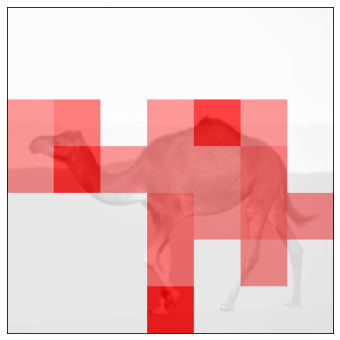

HERE WHAT ALL THE HUMANS AGREE ON


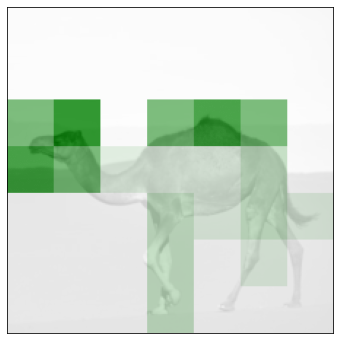

Mean of all standard deviations dim std_image 0.08
Mean of top 10% (5st) standard deviations 0.31
File Path:  study.txt
Experiment Path:  /content/human_saliency/dromedar/
Save Path:  /content/ISMIS/human_saliency/dromedar/
Image Path:  /content/testshapes2/study1/ image nr 0
HERE WHAT ALL THE HUMANS DISAGREE ON


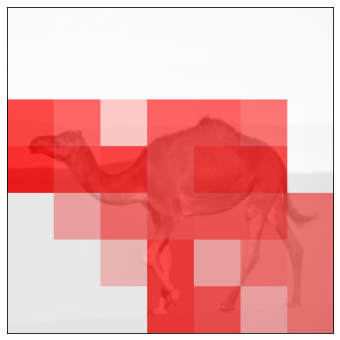

HERE WHAT ALL THE HUMANS AGREE ON


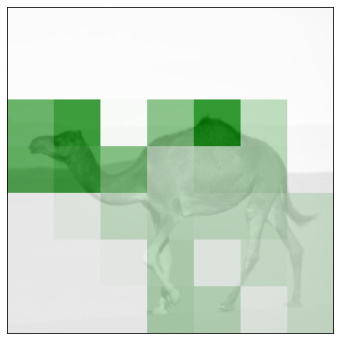

Mean of all standard deviations dim std_image 0.14
Mean of top 10% (5st) standard deviations 0.34
File Path:  all.txt
Experiment Path:  /content/human_saliency/dromedar/
Save Path:  /content/ISMIS/human_saliency/dromedar/
Image Path:  /content/testshapes2/study1/ image nr 0
HERE WHAT ALL THE HUMANS DISAGREE ON


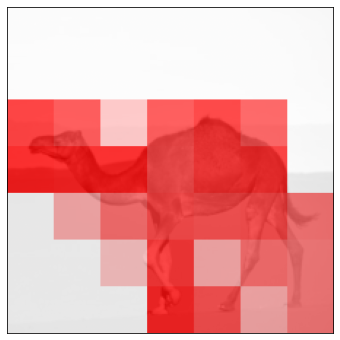

HERE WHAT ALL THE HUMANS AGREE ON


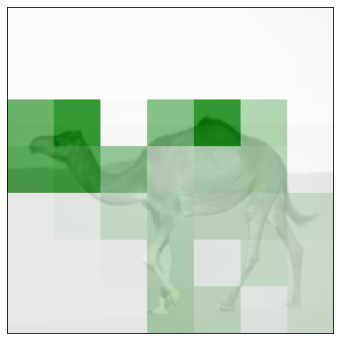

Mean of all standard deviations dim std_image 0.13
Mean of top 10% (5st) standard deviations 0.33
File Path:  design-team.txt
Experiment Path:  /content/human_saliency/gorilla/
Save Path:  /content/ISMIS/human_saliency/gorilla/
Image Path:  /content/testshapes2/study1/ image nr 1
HERE WHAT ALL THE HUMANS DISAGREE ON


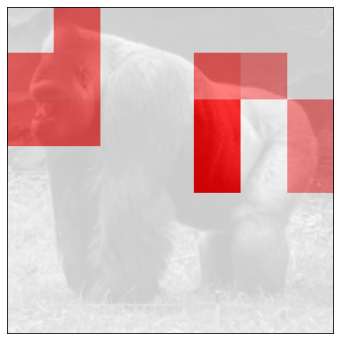

HERE WHAT ALL THE HUMANS AGREE ON


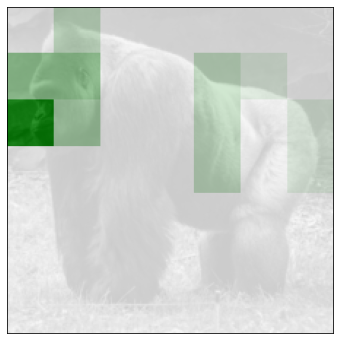

Mean of all standard deviations dim std_image 0.06
Mean of top 10% (5st) standard deviations 0.30
File Path:  study.txt
Experiment Path:  /content/human_saliency/gorilla/
Save Path:  /content/ISMIS/human_saliency/gorilla/
Image Path:  /content/testshapes2/study1/ image nr 1
HERE WHAT ALL THE HUMANS DISAGREE ON


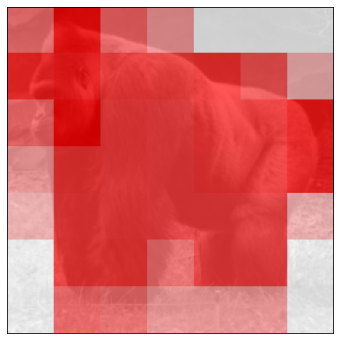

HERE WHAT ALL THE HUMANS AGREE ON


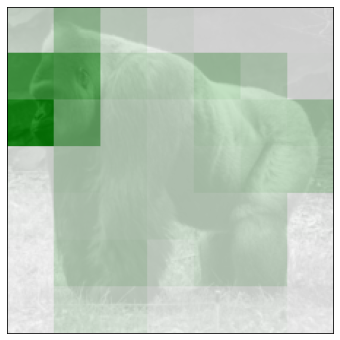

Mean of all standard deviations dim std_image 0.21
Mean of top 10% (5st) standard deviations 0.33
File Path:  all.txt
Experiment Path:  /content/human_saliency/gorilla/
Save Path:  /content/ISMIS/human_saliency/gorilla/
Image Path:  /content/testshapes2/study1/ image nr 1
HERE WHAT ALL THE HUMANS DISAGREE ON


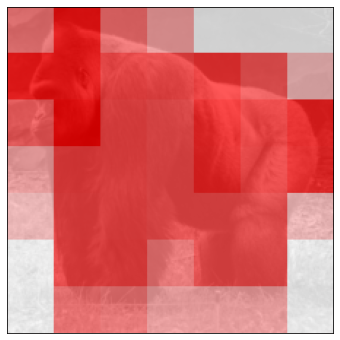

HERE WHAT ALL THE HUMANS AGREE ON


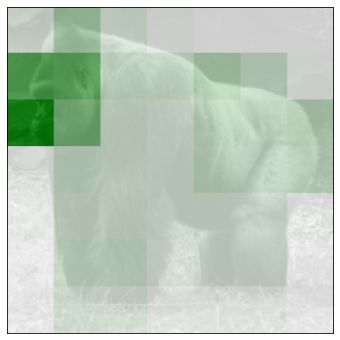

Mean of all standard deviations dim std_image 0.20
Mean of top 10% (5st) standard deviations 0.33
File Path:  design-team.txt
Experiment Path:  /content/human_saliency/tucan/
Save Path:  /content/ISMIS/human_saliency/tucan/
Image Path:  /content/testshapes2/study1/ image nr 2
HERE WHAT ALL THE HUMANS DISAGREE ON


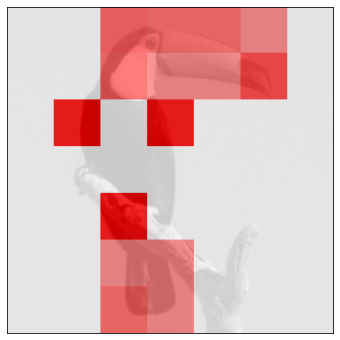

HERE WHAT ALL THE HUMANS AGREE ON


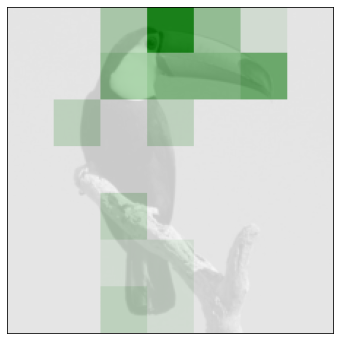

Mean of all standard deviations dim std_image 0.08
Mean of top 10% (5st) standard deviations 0.33
File Path:  study.txt
Experiment Path:  /content/human_saliency/tucan/
Save Path:  /content/ISMIS/human_saliency/tucan/
Image Path:  /content/testshapes2/study1/ image nr 2
HERE WHAT ALL THE HUMANS DISAGREE ON


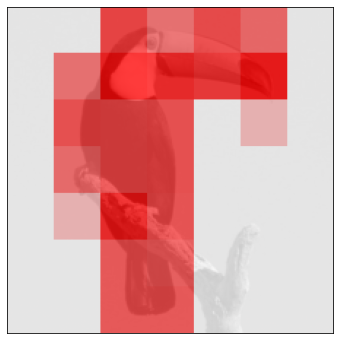

HERE WHAT ALL THE HUMANS AGREE ON


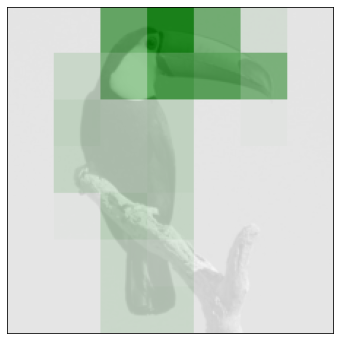

Mean of all standard deviations dim std_image 0.12
Mean of top 10% (5st) standard deviations 0.35
File Path:  all.txt
Experiment Path:  /content/human_saliency/tucan/
Save Path:  /content/ISMIS/human_saliency/tucan/
Image Path:  /content/testshapes2/study1/ image nr 2
HERE WHAT ALL THE HUMANS DISAGREE ON


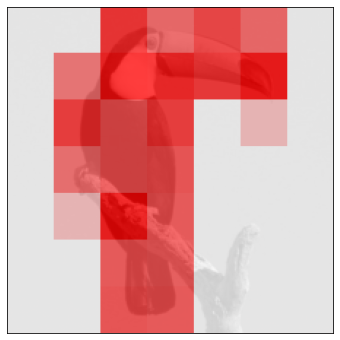

HERE WHAT ALL THE HUMANS AGREE ON


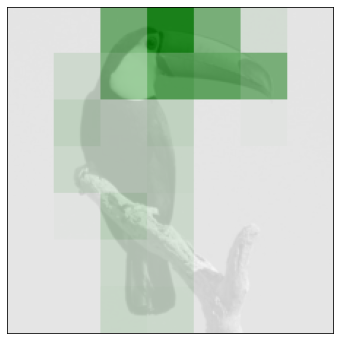

Mean of all standard deviations dim std_image 0.12
Mean of top 10% (5st) standard deviations 0.34


(tensor([0.0000, 0.0000, 0.5000, 0.8710, 0.4677, 0.0806, 0.0000, 0.0000, 0.0968,
         0.4194, 0.6290, 0.5645, 0.4677, 0.0000, 0.0000, 0.1613, 0.1129, 0.1613,
         0.0000, 0.0161, 0.0000, 0.0000, 0.1129, 0.1129, 0.1290, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0161, 0.1774, 0.1129, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.1129, 0.0968, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1290,
         0.1129, 0.0000, 0.0000, 0.0000], dtype=torch.float64),
 tensor([0.0000, 0.0000, 0.3111, 0.2188, 0.2821, 0.2235, 0.0000, 0.0000, 0.1975,
         0.3383, 0.3352, 0.3043, 0.3578, 0.0000, 0.0000, 0.2948, 0.2446, 0.2948,
         0.0000, 0.0883, 0.0000, 0.0000, 0.2091, 0.2446, 0.2530, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0883, 0.3489, 0.2446, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.2446, 0.2348, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2530,
         0.2446, 0.0000, 0.0000, 0.0000], dtype=torch.float64))

In [ ]:
# Most disperate among people
calc_D_score("/content/human_saliency/dromedar/","design-team.txt","/content/testshapes2/study1/",0,'/content/ISMIS/human_saliency/dromedar/')
calc_D_score("/content/human_saliency/dromedar/","study.txt","/content/testshapes2/study1/",0,'/content/ISMIS/human_saliency/dromedar/')
calc_D_score("/content/human_saliency/dromedar/","all.txt","/content/testshapes2/study1/",0,'/content/ISMIS/human_saliency/dromedar/')
calc_D_score("/content/human_saliency/gorilla/","design-team.txt","/content/testshapes2/study1/",1,'/content/ISMIS/human_saliency/gorilla/')
calc_D_score("/content/human_saliency/gorilla/","study.txt","/content/testshapes2/study1/",1,'/content/ISMIS/human_saliency/gorilla/')
calc_D_score("/content/human_saliency/gorilla/","all.txt","/content/testshapes2/study1/",1,'/content/ISMIS/human_saliency/gorilla/')
calc_D_score("/content/human_saliency/tucan/","design-team.txt","/content/testshapes2/study1/",2,'/content/ISMIS/human_saliency/tucan/')
calc_D_score("/content/human_saliency/tucan/","study.txt","/content/testshapes2/study1/",2,'/content/ISMIS/human_saliency/tucan/')
calc_D_score("/content/human_saliency/tucan/","all.txt","/content/testshapes2/study1/",2,'/content/ISMIS/human_saliency/tucan/')


# Run and Compare human and ML saliency maps

resnet101
------------------
Save Path:  /content/ISMIS/study1/resnet101/
{0: {'probability': 0.999999881, 'label': 'Arabian camel', 'labelid': 354}, 1: {'probability': 4.1e-08, 'label': 'llama', 'labelid': 355}, 2: {'probability': 6e-09, 'label': 'gazelle', 'labelid': 353}, 3: {'probability': 5e-09, 'label': 'impala', 'labelid': 352}, 4: {'probability': 4e-09, 'label': 'sorrel', 'labelid': 339}, 5: {'probability': 2e-09, 'label': 'triceratops', 'labelid': 51}, 6: {'probability': 2e-09, 'label': 'lion', 'labelid': 291}, 7: {'probability': 1e-09, 'label': 'Indian elephant', 'labelid': 385}, 8: {'probability': 1e-09, 'label': 'ostrich', 'labelid': 9}, 9: {'probability': 1e-09, 'label': 'hartebeest', 'labelid': 351}, 10: {'probability': 1e-09, 'label': 'cougar', 'labelid': 286}, 11: {'probability': 0.0, 'label': 'brassiere', 'labelid': 459}, 12: {'probability': 0.0, 'label': 'bighorn', 'labelid': 349}, 13: {'probability': 0.0, 'label': 'Chesapeake Bay retriever', 'labelid': 209}, 14: {'pr

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


354 Arabian camel 0.99
inception_v3
------------------
Save Path:  /content/ISMIS/study1/inception_v3/
{0: {'probability': 0.999996901, 'label': 'Arabian camel', 'labelid': 354}, 1: {'probability': 1.163e-06, 'label': 'reel', 'labelid': 758}, 2: {'probability': 5.71e-07, 'label': 'slot', 'labelid': 800}, 3: {'probability': 2.66e-07, 'label': 'bullet train', 'labelid': 466}, 4: {'probability': 1.12e-07, 'label': 'muzzle', 'labelid': 676}, 5: {'probability': 6.8e-08, 'label': 'llama', 'labelid': 355}, 6: {'probability': 3.1e-08, 'label': 'teapot', 'labelid': 849}, 7: {'probability': 2.6e-08, 'label': 'spoonbill', 'labelid': 129}, 8: {'probability': 2.6e-08, 'label': 'mailbag', 'labelid': 636}, 9: {'probability': 2e-08, 'label': 'koala', 'labelid': 105}, 10: {'probability': 1.8e-08, 'label': 'brassiere', 'labelid': 459}, 11: {'probability': 1.5e-08, 'label': 'moped', 'labelid': 665}, 12: {'probability': 1.4e-08, 'label': 'yurt', 'labelid': 915}, 13: {'probability': 1.1e-08, 'label': 'warp

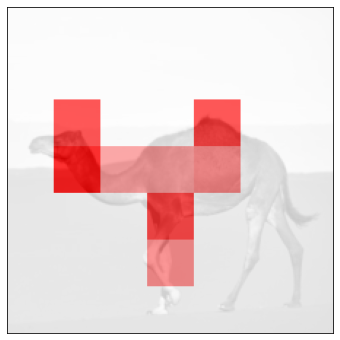

HERE WHAT ALL THE MODELS AGREE ON


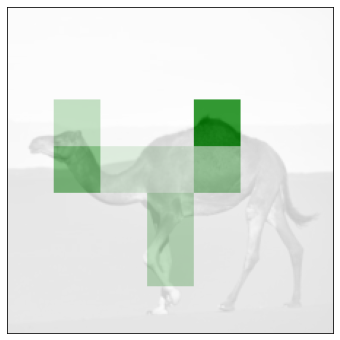

Mean of all standard deviations dim std_image 0.05
Mean of top 10% (5st) standard deviations 0.39
File Path:  design-team.txt
Experiment Path:  /content/human_saliency/dromedar/
Save Path:  /content/ISMIS/human_saliency/dromedar/
Image Path:  /content/testshapes2/study1/ image nr 0
HERE WHAT ALL THE HUMANS DISAGREE ON


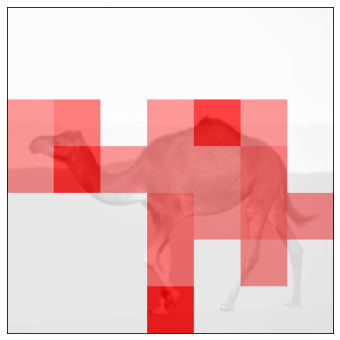

HERE WHAT ALL THE HUMANS AGREE ON


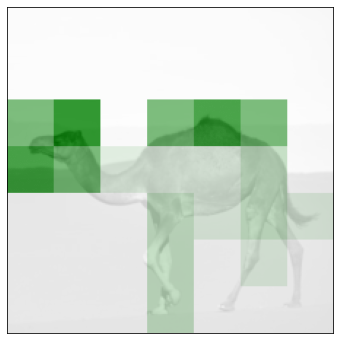

Mean of all standard deviations dim std_image 0.08
Mean of top 10% (5st) standard deviations 0.31
Machine maps tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2000, 0.0000, 0.0000,
        0.7000, 0.0000, 0.0000, 0.0000, 0.4000, 0.1000, 0.1000, 0.3000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.2000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.2000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000])
Human maps tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4167, 0.6667, 0.0000, 0.4167,
        0.5833, 0.4167, 0.0000, 0.5833, 0.4167, 0.0833, 0.0833, 0.0833, 0.1667,
        0.0000, 0.0000, 0.0000, 0.0000, 0.1667, 0.0833, 0.1667, 0.0833, 0.0000,
        0.0000, 0.0000, 0.1667, 0.0000, 0.0833, 0.0000, 0.0000, 0.0000, 0.0000,
        0.1667, 0.0000, 0.0000, 0.000

In [ ]:
#Build mean and std ML model maps
saliency_map=torch.zeros(1,150528) #Variable for collecting saliency maps for the different models 
#saliency_map=torch.zeros(1,49)
x=0 #Dromedar
experiment_path = "/content/testshapes2/study1/"
save_path = '/content/ISMIS/study1/'
saliency_attrib=run_experiment_shapes(model_resnet101, experiment_path ,"resnet101", save_path,  0, x, True, True)
saliency_map = add_saliency_row(saliency_map,saliency_attrib) 
saliency_attrib=run_experiment_shapes(model_resnet152, experiment_path, "resnet152",  save_path, 0, x, True, True)
saliency_map = add_saliency_row(saliency_map,saliency_attrib) 
saliency_attrib=run_experiment_shapes(model_googlenet, experiment_path, "googlenet", save_path, 0, x, True, True)
saliency_map = add_saliency_row(saliency_map,saliency_attrib) 
saliency_attrib= run_experiment_shapes(model_inception_v3, experiment_path, "inception_v3", save_path, 0, x, True, True)
saliency_map = add_saliency_row(saliency_map,saliency_attrib) 
saliency_attrib= run_experiment_shapes( model_efficientnet_b4, experiment_path, "efficientnet_b0", save_path, 0, x, True, True)
saliency_map = add_saliency_row(saliency_map,saliency_attrib)
result_mean_and_std_machine_maps = calc_show_difference(saliency_map,experiment_path,save_path,x)

#Build and create mean and std human maps
result_mean_and_std_human_maps=calc_D_score("/content/human_saliency/dromedar/","design-team.txt","/content/testshapes2/study1/",0,'/content/ISMIS/human_saliency/dromedar/')
# calc_D_score("/content/human_saliency/dromedar/","study.txt","/content/testshapes2/study1/",0,'/content/ISMIS/human_saliency/dromedar/')
# calc_D_score("/content/human_saliency/dromedar/","all.txt","/content/testshapes2/study1/",0,'/content/ISMIS/human_saliency/dromedar/')
# calc_D_score("/content/human_saliency/gorilla/","design-team.txt","/content/testshapes2/study1/",1,'/content/ISMIS/human_saliency/gorilla/')
# calc_D_score("/content/human_saliency/gorilla/","study.txt","/content/testshapes2/study1/",1,'/content/ISMIS/human_saliency/gorilla/')
# calc_D_score("/content/human_saliency/gorilla/","all.txt","/content/testshapes2/study1/",1,'/content/ISMIS/human_saliency/gorilla/')
# calc_D_score("/content/human_saliency/tucan/","design-team.txt","/content/testshapes2/study1/",2,'/content/ISMIS/human_saliency/tucan/')
# calc_D_score("/content/human_saliency/tucan/","study.txt","/content/testshapes2/study1/",2,'/content/ISMIS/human_saliency/tucan/')
# calc_D_score("/content/human_saliency/tucan/","all.txt","/content/testshapes2/study1/",2,'/content/ISMIS/human_saliency/tucan/')

print("Machine maps mean",result_mean_and_std_machine_maps[0])
print("Human maps mean",result_mean_and_std_human_maps[0])
# subtract the maps
disagre_importance = torch.subtract(result_mean_and_std_machine_maps[0],result_mean_and_std_human_maps[0])
print("disagree on",disagre_importance)
print(torch.abs(disagre_importance))

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2000, 0.0000, 0.0000,
        0.7000, 0.0000, 0.0000, 0.0000, 0.4000, 0.1000, 0.1000, 0.3000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.2000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.2000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000])
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4167, 0.6667, 0.0000, 0.4167,
        0.5833, 0.4167, 0.0000, 0.5833, 0.4167, 0.0833, 0.0833, 0.0833, 0.1667,
        0.0000, 0.0000, 0.0000, 0.0000, 0.1667, 0.0833, 0.1667, 0.0833, 0.0000,
        0.0000, 0.0000, 0.1667, 0.0000, 0.0833, 0.0000, 0.0000, 0.0000, 0.0000,
        0.1667, 0.0000, 0.0000, 0.0000], dtype=torch.float64)
torch.Size([1, 3, 7, 7])


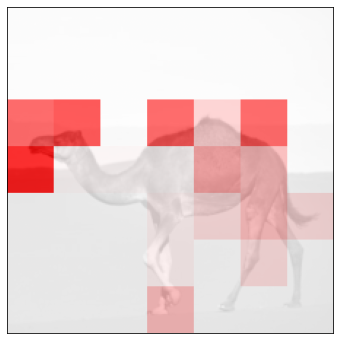

In [ ]:
image_path="/content/testshapes2/study1/"
image_index=0
print(result_mean_and_std_machine_maps[0])
print(result_mean_and_std_human_maps[0])
disagre_importance = torch.subtract(result_mean_and_std_machine_maps[0],result_mean_and_std_human_maps[0])
disagre_importance = torch.abs(disagre_importance)
disagre_importance = rebuild_saliency_map(disagre_importance)
print(disagre_importance.shape)
experiment_set = load_experiment_data(image_path,  "dummy_name", plot_data=False, evaluate_model = False, print_evaluation=False) #Only usin this to get the image sp model name not important
experiment_sample = experiment_set[image_index]
input_img = experiment_sample.unsqueeze(0)
input_img = input_img.to(device)
input_img = input_img.squeeze()
attributions = LayerAttribution.interpolate(torch.negative(disagre_importance), [224,224]) #and this?
result_mean=viz.visualize_image_attr(attributions[0].cpu().permute(1,2,0).detach().numpy(),
                                    input_img.cpu().permute(1,2,0).detach().numpy(),  
                                    #cmap=default_cmap,
                                    alpha_overlay=alpha_overlay,
                                    method="blended_heat_map",
                                    sign="all",
                                    fig_size=(6,6))

### zip and go


In [ ]:
zip_name = "ismis_human_saliency_last1"
XAI_compress = "/"
import shutil
shutil.make_archive("/content/"+zip_name, 'zip', "/content/ISMIS")

'/content/ismis_human_saliency_last1.zip'

In [ ]:
! rm -r ISMIS
#rm -r human_saliency

# crap below

In [ ]:
print(saliency_map.shape)
attributions = LayerAttribution.interpolate(torch.negative(saliency_map), [224,224]) #and this?
result=viz.visualize_image_attr(attributions[0].cpu().permute(1,2,0).detach().numpy(),
                                    #input_img.cpu().permute(1,2,0).detach().numpy(),  
                                    #cmap=default_cmap,
                                    alpha_overlay=alpha_overlay,
                                    method="heat_map",
                                    sign="all",
                                    fig_size=(6,6))

torch.Size([1, 150528])

In [ ]:
x = torch.randn(28, 28)
print(x.shape)
x.unsqueeze_(0)
print(x.shape)
x = x.repeat(3, 1, 1)
x.shape

torch.Size([28, 28])
torch.Size([1, 28, 28])


torch.Size([3, 28, 28])

In [ ]:
import torch
import numpy as np

a = np.random.uniform(0,1,(10,10))
a = torch.tensor(a)
print(a.shape)
a = a.unsqueeze(0).unsqueeze(0)
print(a.shape)
upsampler = torch.nn.Upsample(size=20, mode='bilinear')

a_sized_up = upsampler(a)

print(a_sized_up.shape)

torch.Size([10, 10])
torch.Size([1, 1, 10, 10])
torch.Size([1, 1, 20, 20])


In [ ]:
#150528
input = torch.randn(1,7,7).view(1,7,7)
print(input)
upsample2 = torch.nn.Upsample(size=[1,224, 224])
#upsample1 = torch.nn.Upsample(scale_factor=(1024*3))
output1 = upsample2(input)
print(output1.shape)
print("Upsample by a scale_factor=2\n", output1)
output1 = torch.flatten(output1)
output1=output1[None, :]
output1=torch.reshape(output1, (1,3,224,224))
print(output1.shape)


tensor([[[ 0.2800, -0.8990,  0.6984,  0.5535,  0.6689,  1.6736,  0.2042],
         [ 1.1998,  0.3377, -0.8410, -0.6181, -0.1033, -0.9970, -1.9045],
         [-0.4588, -0.8802, -0.4455,  1.2920, -0.8549, -0.3787,  0.7045],
         [-0.1124,  1.2748, -0.4264,  1.1408,  1.2428,  0.4321, -1.5601],
         [-0.1084, -0.9310,  1.8935,  0.1475,  0.6312,  0.2175, -1.6730],
         [ 0.0125, -0.1386, -0.9854, -1.1709,  0.7008, -0.1480,  0.0324],
         [ 1.2912,  0.1852,  0.4616,  1.3527,  1.1401,  0.5679, -0.0035]]])


ValueError: ignored

resnet101
------------------
Save Path:  /content/ISMIS/study1/resnet101/
{0: {'probability': 0.999651313, 'label': 'toucan', 'labelid': 96}, 1: {'probability': 0.000295982, 'label': 'hornbill', 'labelid': 93}, 2: {'probability': 5.279e-06, 'label': 'lorikeet', 'labelid': 90}, 3: {'probability': 4.65e-06, 'label': 'macaw', 'labelid': 88}, 4: {'probability': 3.922e-06, 'label': 'vulture', 'labelid': 23}, 5: {'probability': 3.509e-06, 'label': 'albatross', 'labelid': 146}, 6: {'probability': 2.937e-06, 'label': 'king penguin', 'labelid': 145}, 7: {'probability': 2.784e-06, 'label': 'bee eater', 'labelid': 92}, 8: {'probability': 1.709e-06, 'label': 'coucal', 'labelid': 91}, 9: {'probability': 1.439e-06, 'label': 'magpie', 'labelid': 18}, 10: {'probability': 1.255e-06, 'label': 'bulbul', 'labelid': 16}, 11: {'probability': 1.194e-06, 'label': 'African grey', 'labelid': 87}, 12: {'probability': 1.117e-06, 'label': 'bald eagle', 'labelid': 22}, 13: {'probability': 1.068e-06, 'label': 'jacam

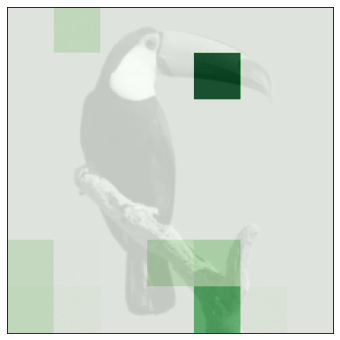

96 toucan 1.0
return from occ torch.Size([1, 3, 224, 224])
top_norm tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
ett tensor([[0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.]])
Saliency_attrib tensor([[0., 0., 0.,  ..., 0., 0., 0.]])
Adding saliency row with shape  torch.Size([1, 150528])  The 10 max numbers are:  tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])  and the mins are 
Min value is: tensor(0.)  and max is  tensor(1.)
Ett torch.Size([1, 150528])
Två torch.Size([1, 3, 224, 224])
Tre torch.Size([1, 3, 224, 224])


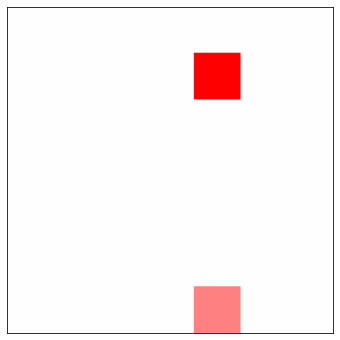

In [ ]:
saliency_map=torch.zeros(1,150528) #Variable for collecting saliency maps for the different models 
experiment_path = "/content/testshapes2/study1/"
save_path = '/content/ISMIS/study1/'
saliency_attrib=run_experiment_shapes(model_resnet101, experiment_path ,"resnet101", save_path,  0, x, True, True)
saliency_map = add_saliency_row(saliency_map,saliency_attrib) 
print("Ett",saliency_map.shape)
std_saliency_map_aggregate_image=torch.reshape(saliency_map, (1,3,224,224))
print("Två",std_saliency_map_aggregate_image.shape)
attributions = LayerAttribution.interpolate(torch.negative(std_saliency_map_aggregate_image), [224,224]) #and this?
print("Tre",attributions.shape)
result=viz.visualize_image_attr(attributions[0].cpu().permute(1,2,0).detach().numpy(),
                                    #input_img.cpu().permute(1,2,0).detach().numpy(),  
                                    #cmap=default_cmap,
                                    alpha_overlay=alpha_overlay,
                                    method="heat_map",
                                    sign="all",
                                    fig_size=(6,6))